#  Automatic Panoramic Image Stitching 

## 1. Interest points detection & feature description by SIFT

https://stackoverflow.com/questions/52305578/sift-cv2-xfeatures2d-sift-create-not-working-even-though-have-contrib-instal

[Introduction to SIFT (Scale-Invariant Feature Transform)](https://docs.opencv.org/3.4/da/df5/tutorial_py_sift_intro.html)

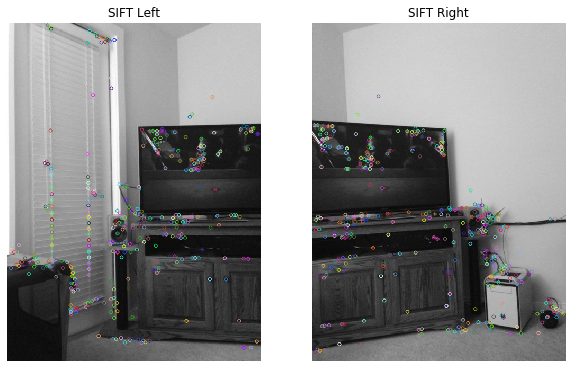

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
plt.rcParams['figure.figsize'] = 10,8

img1 = cv2.imread('data/2.jpg')
img2 = cv2.imread('data/1.jpg')
#plt.imshow(img1[:,:,::-1])

def SIFT(img1, img2, feature='sift'):
    gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    
    
    if feature == 'sift':
        sift = cv2.xfeatures2d_SIFT.create()
        kp1, des1 = sift.detectAndCompute(gray1, None) # cv.drawKeypoints(image, keypoints, outImage[, color[, flags]])
        kp2, des2 = sift.detectAndCompute(gray2, None) 
    
    # SURF: Speeded Up Robust Features. ECCV 2006
    if feature == 'surf':
        surf = cv2.xfeatures2d_SURF.create()
        kp1, des1 = surf.detectAndCompute(gray1, None) # cv.drawKeypoints(image, keypoints, outImage[, color[, flags]])
        kp2, des2 = surf.detectAndCompute(gray2, None) 
        
    # ORB: An efficient alternative to SIFT or SURF. ICCV 2011
    elif feature == 'orb':
        orb = cv2.ORB_create()
        kp1, des1 = orb.detectAndCompute(gray1, None)
        kp2, des2 = orb.detectAndCompute(gray2, None)
    
    # Maximally stable extremal region extractor
    elif feature== 'mser':
        mser = cv2.MSER.create()
        kp1 = mser.detect(gray1)
        kp2 = mser.detect(gray2)        
    
    # Binary Robust Invariant Scalable Keypoints. ICCV 2011
    elif feature == 'brisk':
        brisk = cv2.BRISK_create()
        kp1, des1 = brisk.detectAndCompute(gray1, None)
        kp2, des2 = brisk.detectAndCompute(gray2, None)
        
    kp_img1 = np.zeros_like(img1)
    kp_img2 = np.zeros_like(img2)
    kp_img1 = cv2.drawKeypoints(gray1, kp1, kp_img1) #flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    kp_img2 = cv2.drawKeypoints(gray2, kp2, kp_img2) #flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS) 
    plt.subplot(1,2,1)
    plt.axis('off')
    plt.title('SIFT Left')
    plt.imshow(kp_img2)
    plt.subplot(1,2,2)
    plt.axis('off')
    plt.title('SIFT Right')
    plt.imshow(kp_img1)
    
    return kp1, kp2, des1, des2
    

feature = 'sift'
kp1, kp2, des1, des2 = SIFT(img1, img2, feature=feature)

## 2. Feature matching by SIFT features

[Feature Matching](https://www.docs.opencv.org/3.4.2/dc/dc3/tutorial_py_matcher.html)

- DMatch.distance - Distance between descriptors. The lower, the better it is.
- DMatch.trainIdx - Index of the descriptor in train descriptors
- DMatch.queryIdx - Index of the descriptor in query descriptors
- DMatch.imgIdx - Index of the train image.

In [2]:
class DMatch():
    distance: float
    trainIdx: int
    queryIdx: int
    imgIdx: int

    def __init__(self):
        self.distance = 0.0
        self.trainIdx = 0
        self.queryIdx = 0
        self.imgIdx = 0
        
def knnMatch(des1, des2, k):
    n1, m1 = des1.shape
    n2, m2 = des2.shape

    dmatch_ary_final = []
    for i in range(n1):
        # calculate distance from des1 i to each des2
        dist_array = []
        dist_idx_array = []
        for j in range(n2):
            dist = np.sqrt(np.sum(np.square(des1[i] - des2[j])))
            dist_array.append(dist)
            dist_idx_array.append(j)

        # sort dist_array
        combined = zip(dist_array, dist_idx_array)
        zipped_sorted = sorted(combined, key=lambda x: x[0])
        dist_array, dist_idx_array = map(list, zip(*zipped_sorted))

        # select k smallest dist to be the result
        dmatch_ary = []
        for kn in range(k):
            dmatch = DMatch()
            dmatch.queryIdx = i
            dmatch.trainIdx = int(dist_idx_array[kn])
            dmatch.imgIdx = 0
            dmatch.distance = dist_array[kn]
            dmatch_ary.append(dmatch)

        dmatch_ary_final.append(dmatch_ary.copy())

    return dmatch_ary_final

def randomcolor():
    r = np.random.randint(0, 255)
    g = np.random.randint(0, 255)
    b = np.random.randint(0, 255)

    return [b, g, r]

def drawMatchesKnn(img1, kp1, img2, kp2, good):

    # Combine two images
    result = np.concatenate((img1, img2), axis=1)

    # Collect descriptors' coordinate
    src_temp = []
    dst_temp = []
    for i in good:
        src_temp.append(kp1[i[0].queryIdx].pt)
        dst_temp.append(kp2[i[0].trainIdx].pt)
    src_pts = np.asarray(src_temp) # (n,2)
    dst_pts = np.asarray(dst_temp) # (n,2)

    n, _ = src_pts.shape
    h1, w1, c1 = img1.shape
    
    for i in range(n):
        color = randomcolor()
        x1 = int(src_pts[i,0])
        y1 = int(src_pts[i,1])
        cv2.circle(result, (x1, y1), 7, color, 1)

        x2 = w1 + int(dst_pts[i,0])
        y2 = int(dst_pts[i,1])
        cv2.circle(result, (x2, y2), 7, color, 1)

        # (y-y1) / (y2-y1) - (x-x1) / (x2-x1)
        for x in range(x1, x2):
            y = y1 + ((x-x1)/(x2-x1)*(y2-y1))
            result[int(y), x] = color
        #cv2.line(result, (x1,y1), (x2, y2), color, 1)

    return result

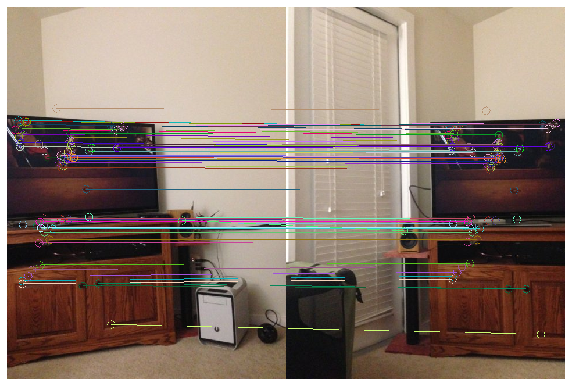

In [3]:
def Feature_matching(kp1, kps2, des1, des2, img1, img2, match_thres=0.5):
    
    # BFMatcher
    matches = knnMatch(des1, des2, k=2)

    # Apply ratio test
    good = []
    for m, n in matches:
        if m.distance < match_thres * n.distance: # 1st is more better than 2nd
            good.append([m])
    
    # Store descriptors' coordinate
    src_temp = []
    dst_temp = []
    for m in good:
        src_temp.append(kp1[m[0].queryIdx].pt)
        dst_temp.append(kp2[m[0].trainIdx].pt)
    src_pts = np.asarray(src_temp) # (n,2)
    dst_pts = np.asarray(dst_temp) # (n,2)
    

    
    img3 = drawMatchesKnn(img1, kp1, img2, kp2, good)
    plt.axis('off')
    plt.imshow(img3[:,:,::-1])
    
    return src_pts, dst_pts

src_pts, dst_pts = Feature_matching(kp1, kp2, des1, des2, img1, img2)

## 3. RANSAC to find homography matrix H

$s_{i}\left[\begin{array}{c}x_{i}^{\prime} \\ y_{i}^{\prime} \\ 1\end{array}\right] \sim H\left[\begin{array}{c}x_{i} \\ y_{i} \\ 1\end{array}\right]$

$p_{i}=\left[\begin{array}{cccccccc}-x_{i} & -y_{i} & -1 & 0 & 0 & 0 & x_{i} x_{i}^{\prime} & y_{i} x_{i}^{\prime} & x_{i}^{\prime} \\ 0 & 0 & 0 & -x_{i} & -y_{i} & -1 & x_{i} y_{i}^{\prime} & y_{i} y_{i}^{\prime} & y_{i}^{\prime}\end{array}\right]$

$P H=\left[\begin{array}{cccccccc}-x_{1} & -y_{1} & -1 & 0 & 0 & 0 & x_{1} x_{1}^{\prime} & y_{1} x_{1}^{\prime} & x_{1}^{\prime} \\ 0 & 0 & 0 & -x_{1} & -y_{1} & -1 & x_{1} y_{1}^{\prime} & y_{1} y_{1}^{\prime} & y_{1}^{\prime} \\ -x_{2} & -y_{2} & -1 & 0 & 0 & 0 & x_{2} x_{2}^{\prime} & y_{2} x_{2}^{\prime} & x_{2}^{\prime} \\ 0 & 0 & 0 & -x_{2} & -y_{2} & -1 & x_{2} y_{2}^{\prime} & y_{2} y_{2}^{\prime} & y_{2}^{\prime} \\ -x_{3} & -y_{3} & -1 & 0 & 0 & 0 & x_{3} x_{3}^{\prime} & y_{3} x_{3}^{\prime} & x_{3}^{\prime} \\ 0 & 0 & 0 & -x_{3} & -y_{3} & -1 & x_{3} y_{3}^{\prime} & y_{3} y_{3}^{\prime} & y_{3}^{\prime} \\ -x_{4} & -y_{4} & -1 & 0 & 0 & 0 & x_{4} x_{4}^{\prime} & y_{4} x_{4}^{\prime} & x_{4}^{\prime} \\ 0 & 0 & 0 & -x_{4} & -y_{4} & -1 & x_{4} y_{4}^{\prime} & y_{4} y_{4}^{\prime} & y_{4}^{\prime}\end{array}\right]\left[\begin{array}{c}h 1 \\ h 2 \\ h 3 \\ h 4 \\ h 5 \\ h 6 \\ h 7 \\ h 8 \\ h 9\end{array}\right]=0$

In [4]:
def Homography_Matrix(points_in_img1, points_in_img2):
    num_points, _ = points_in_img1.shape
    P = []
    for i in range(num_points):
        x, y = points_in_img1[i]
        x_prime, y_prime = points_in_img2[i]
        pi = np.array([[-x, -y, -1, 0, 0, 0, x*x_prime, y*x_prime, x_prime],
                       [0, 0, 0, -x, -y, -1, x*y_prime, y*y_prime, y_prime]])
        P.append(pi)
    
    P = np.array(P).reshape(-1, 9)
    
    # solve PH=0, H is the last column of v
    u, s, vh = np.linalg.svd(P) # vh (9,9)
    H = (vh.T[:,-1] / vh[-1,-1]).reshape(3, 3)

    return H


def RANSAC(src_pts, dst_pts, num_sample, iteration, threshold):
    
    num_points, _ = src_pts.shape
    best = np.inf
    H = 0
    for i in range(iteration):
        rand_idx = np.arange(num_points)
        np.random.shuffle(rand_idx)
        rand_idx = rand_idx[:num_sample]
        points_in_img1 = src_pts[rand_idx]
        points_in_img2 = dst_pts[rand_idx]

        h = Homography_Matrix(points_in_img1, points_in_img2) # H (3,3)
        src_sample = np.hstack((src_pts, np.ones((num_points, 1)))) # src matrix has to be (n,3)
        dst_sample = np.hstack((dst_pts, np.ones((num_points, 1)))) # dst matrix has to be (n,3)
        # np.insert(src_pts, 2, values=1, axis=1)
        # np.insert(dst_pts, 2, values=1, axis=1)

        prediction = (h @ src_sample.T).T
        loss = np.sum(abs(dst_sample - prediction)) / num_points

        if (loss < threshold) and (loss < best):
            H = h
            best = loss

    return H

H = RANSAC(src_pts, dst_pts, 50, 1000, 500)
H

array([[ 6.32222936e-01, -6.19572850e-03,  2.68271447e+02],
       [-2.34617872e-01,  9.28100081e-01,  2.55978207e+01],
       [-7.77183256e-04,  1.53354631e-05,  1.00000000e+00]])

## 4. Warp image to create panoramic image

In [5]:
def Homography_boundary(H, img):
    """ Decide the range after homography transform """
    corners = np.array([[0, 0, 1],
                        [img.shape[1], 0, 1],
                        [0, img.shape[0], 1],
                        [img.shape[1], img.shape[0], 1]]) # (4,3)
    

    out_unnorm = H @ corners.T
    out = out_unnorm / out_unnorm[-1, :]
    
    x_min = out[0,:].min()
    x_max = out[0,:].max()
    y_min = out[1,:].min()
    y_max = out[1,:].max()
    return int(x_min), int(x_max), int(y_min), int(y_max)


def Image_coord(x_min, x_max, y_min, y_max):
    """ output (x, y) coordinate """
    h = y_max - y_min + 1 # y_gap
    w = x_max - x_min + 1 # x_gap
    out = np.zeros([2, h*w], dtype=np.float)
    for i in range(h):
        for j in range(w):
            k = i*w + j
            out[0, k] = j + x_min # x coordinate + start point
            out[1, k] = i + y_min # y coordinate + start point
    return out



def bilinear_interpolate(x, y, x1, x2, y1, y2, q11, q12, q21, q22):
    """
    y1 -+--------+-        q11    q21
        |        |
    y2 -+--------+-        q12    q22
        x1       x2

    """
    return (q11 * (x2 - x) * (y2 - y) +
            q21 * (x - x1) * (y2 - y) +
            q12 * (x2 - x) * (y - y1) +
            q22 * (x - x1) * (y - y1)
           ) / ((x2 - x1) * (y2 - y1) + 0.0)


def my_warp_perspective(img, coord_origin, coord_homo, out_size, shift):
    """
    :param im: rgb image
    :param coord_origin: the coords in the origin coordinate from grid coords on the homography image (2 * num_pixels)
    :param coord_homo: the grid coords on the homography image (3 * num_pixels), last row is 1
    :param out_size: output size (row, col) differs from opencv
    :param shift: shift image after homography transform is done so that all image can be in the canvas
    :return:
    """
    # Initialization
    xhomos, yhomos, xs, ys = [], [], [], []
    x1s, x2s, y1s, y2s = [], [], [], []
    q11_rs, q11_gs, q11_bs = [], [], []
    q12_rs, q12_gs, q12_bs = [], [], []
    q21_rs, q21_gs, q21_bs = [], [], []
    q22_rs, q22_gs, q22_bs = [], [], []

    # To find RGB's interpolation parameters
    for i in range(coord_origin.shape[1]):
        x, y = coord_origin[0, i], coord_origin[1, i]
        if (0 <= x <= img.shape[1]-1) and (0 <= y <= img.shape[0]-1):  # valid pixels in the original coordinate
            x1 = np.floor(x)
            x2 = np.ceil(x)
            y1 = np.floor(y)
            y2 = np.ceil(y)
            xhomos.append(coord_homo[0, i])
            yhomos.append(coord_homo[1, i])
            xs.append(x)
            ys.append(y)
            x1s.append(x1)
            x2s.append(x2)
            y1s.append(y1)
            y2s.append(y2)
            q11_rs.append(img[int(y1),int(x1),0])
            q11_gs.append(img[int(y1),int(x1),1])
            q11_bs.append(img[int(y1),int(x1),2])
            q12_rs.append(img[int(y2),int(x1),0])
            q12_gs.append(img[int(y2),int(x1),1])
            q12_bs.append(img[int(y2),int(x1),2])
            q21_rs.append(img[int(y1),int(x2),0])
            q21_gs.append(img[int(y1),int(x2),1])
            q21_bs.append(img[int(y1),int(x2),2])
            q22_rs.append(img[int(y2),int(x2),0])
            q22_gs.append(img[int(y2),int(x2),1])
            q22_bs.append(img[int(y2),int(x2),2])
    xhomos = np.array(xhomos)
    yhomos = np.array(yhomos)
    xs = np.array(xs)
    ys = np.array(ys)
    x1s = np.array(x1s)
    x2s = np.array(x2s)
    y1s = np.array(y1s)
    y2s = np.array(y2s)
    q11_rs = np.array(q11_rs)
    q11_gs = np.array(q11_gs)
    q11_bs = np.array(q11_bs)
    q12_rs = np.array(q12_rs)
    q12_gs = np.array(q12_gs)
    q12_bs = np.array(q12_bs)
    q21_rs = np.array(q21_rs)
    q21_gs = np.array(q21_gs)
    q21_bs = np.array(q21_bs)
    q22_rs = np.array(q22_rs)
    q22_gs = np.array(q22_gs)
    q22_bs = np.array(q22_bs)

    # Bilinear interpolation
    values_r = bilinear_interpolate(xs, ys, x1s, x2s, y1s, y2s, q11_rs, q12_rs, q21_rs, q22_rs)
    values_g = bilinear_interpolate(xs, ys, x1s, x2s, y1s, y2s, q11_gs, q12_gs, q21_gs, q22_gs)
    values_b = bilinear_interpolate(xs, ys, x1s, x2s, y1s, y2s, q11_bs, q12_bs, q21_bs, q22_bs)
    values = np.stack([xhomos, yhomos, values_r, values_g, values_b], axis=0)

    # Fill in values
    out = np.zeros([out_size[0], out_size[1], 3]) # out_size is 3*left image size
    for i in range(values.shape[1]):
        # coordinate < 0, should shift image
        # if values[1,i] < 0 or values[0,i] < 0:
        #     continue
        out[int(values[1,i])+shift[0], int(values[0,i])+shift[1]] = values[2:,i]
    out = out.astype(np.uint8)
    return out

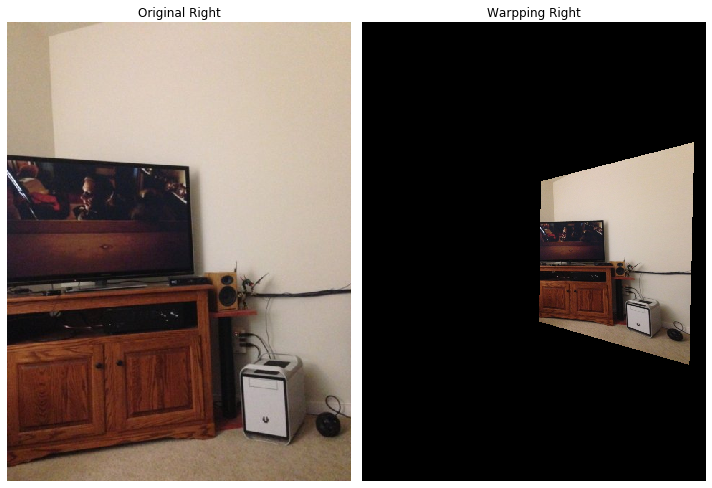

In [6]:
def Warp(img1, img2, H):

    # Find image boundary after doing homography
    x_min, x_max, y_min, y_max = Homography_boundary(H, img1)
    coord_homo = Image_coord(x_min, x_max, y_min, y_max) # (2, n_pixels)
    
    # Transform coordinate back to the origin coordinate
    coord_homo = np.vstack((coord_homo, np.ones((1,coord_homo.shape[1])))) # (3, n_pixels)
    coord_origin = np.linalg.inv(H) @ coord_homo
    coord_origin = coord_origin / coord_origin[-1, :] # Normalization
    
    # Transform image
    left_img_shape = (img2.shape[0], img2.shape[1])
    img1_homo = my_warp_perspective(img1, coord_origin, coord_homo, (left_img_shape[0]*3, left_img_shape[1]*3), left_img_shape)
    
    plt.subplot(1,2,1)
    plt.axis('off')
    plt.title('Original Right')
    plt.imshow(img1[:,:,::-1])
    
    plt.subplot(1,2,2)
    plt.axis('off')
    plt.title('Warpping Right')
    plt.imshow(img1_homo[:,:,::-1])
    
    plt.tight_layout()
    
    return img1_homo   
    
img1_homo = Warp(img1, img2, H)

## Stitching

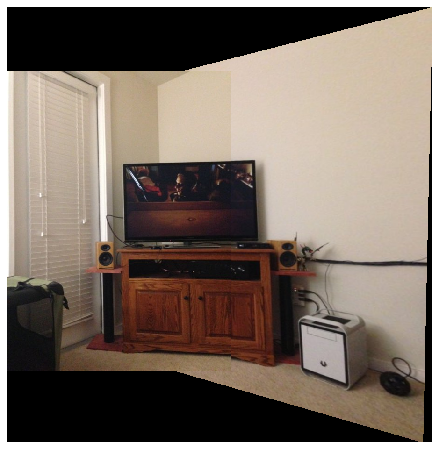

In [7]:
def Crop_img(img):
    img = img.astype(float)
    channel_sum = (np.sum(img, axis=2)).astype(float) # (h,w)

    # Find Left and Right Image Boundary
    col_sum = np.sum(channel_sum, axis=0) # (w,)
    col_non_zero = np.where(col_sum!=0)[0]
    left = col_non_zero[0]
    right = col_non_zero[-1]

    # Find Top and bottom Image Boundary
    row_sum = np.sum(channel_sum, axis=1) # (h,)
    row_non_zero = np.where(row_sum!=0)[0]
    top = row_non_zero[0]
    bot = row_non_zero[-1]

    return top, bot, left, right

def Stitching(img1, img2, img1_homo):
    img_stitching = np.array(img1_homo)
    img_stitching[img2.shape[0]:img2.shape[0]*2, img2.shape[1]:img2.shape[1]*2, :] = img2

    # Crop Image
    top, bot, left, right = Crop_img(img_stitching)
    img_stitching_cut = img_stitching[top:bot, left:right]
    plt.axis('off')
    plt.imshow(img_stitching_cut[:,:,::-1])
    
    return img_stitching
    
img_stitching = Stitching(img1, img2, img1_homo)